<a href="https://colab.research.google.com/github/SHASHANK8412/Logistic_Regression/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## "Research on Disease Classification Model and Algorithms Based on Gene Expression Data"


**Research Gap:**




The proposed classification model and algorithm in this study currently only support data binary classification (e.g., differentiating between two classes). Therefore, a significant research gap lies in developing a multi-population data classification model to handle more complex disease types. Furthermore, the model does not explicitly account for the interaction between genes, which is a crucial biological reality, presenting another area for future refinement. Finally, a key gap for practical application is determining how to construct the classification model and conduct on-line pathological analysis with the assistance of large network data, integrating the current approach with big data for real-time clinical insights.

Importing Libraries

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Loading Dataset

In [27]:
df = pd.read_csv("Colorectal Cancer Gene Expression Data.csv")

# Clean column names
df.columns = df.columns.str.strip().str.replace('"', '').str.replace("'", "")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# If ID_REF exists, use it as index
if 'ID_REF' in df.columns:
    df.set_index('ID_REF', inplace=True)
else:
    df.set_index(df.columns[0], inplace=True)

# Transpose: samples as rows, genes as columns
df_T = df.transpose()


num_samples = df_T.shape[0]
num_cancer = num_samples // 2
labels = ['Cancer'] * num_cancer + ['Normal'] * (num_samples - num_cancer)
y = np.array(labels)


Preprocessing

In [17]:
df_T = df.transpose()
print(" Transposed dataset shape:", df_T.shape)
print("Samples:", df_T.index[:5])


# Example assumption: first 30 = Cancer, next 30 = Normal
# ⚠️ Adjust based on your dataset (use correct numbers of samples)
n_samples = df_T.shape[0]
labels = ['Cancer'] * 30 + ['Normal'] * 30
labels = labels[:n_samples]  # Trim to match total samples

# Convert to array
y = np.array(labels)
print(f" Assigned {len(y)} labels (Cancer/Normal)")

 Transposed dataset shape: (62, 1935)
Samples: Index(['GSM877126', 'GSM877127', 'GSM877128', 'GSM877129', 'GSM877130'], dtype='object')
 Assigned 60 labels (Cancer/Normal)


Feature Scaling

In [29]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_T)

PCA

In [30]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

Split the Data

In [31]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

Define Parameters Grid for Tuning


In [41]:
ada_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}


Grid Search

In [33]:
print("🔍 Performing Hyperparameter Tuning...")

grid_ada = GridSearchCV(AdaBoostClassifier(), ada_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_ada.fit(X_train, y_train)
best_ada = grid_ada.best_estimator_
print("✅ Best AdaBoost Params:", grid_ada.best_params_)

grid_svm = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_
print("✅ Best SVM Params:", grid_svm.best_params_)

grid_knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_
print("✅ Best KNN Params:", grid_knn.best_params_)


🔍 Performing Hyperparameter Tuning...
✅ Best AdaBoost Params: {'learning_rate': 1.0, 'n_estimators': 50}
✅ Best SVM Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
✅ Best KNN Params: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan 0.44666667 0.48888889 0.48888889        nan 0.50666667
 0.56888889 0.56888889        nan 0.50666667 0.52888889 0.52888889
        nan 0.61111111 0.54888889 0.54888889]
  warnings.warn(


Ensemble Voting

In [40]:
voting_model = VotingClassifier(
    estimators=[
        ('AdaBoost', best_ada),
        ('SVM', best_svm),
        ('KNN', best_knn)
    ],
    voting='hard'
)
voting_model.fit(X_train, y_train)
y_pred = voting_model.predict(X_test)

Evaluation metrics after tuning



In [36]:
print("\n=== Ensemble Model Evaluation (After Tuning) ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


=== Ensemble Model Evaluation (After Tuning) ===
Accuracy: 0.46153846153846156

Classification Report:
               precision    recall  f1-score   support

      Cancer       0.50      0.71      0.59         7
      Normal       0.33      0.17      0.22         6

    accuracy                           0.46        13
   macro avg       0.42      0.44      0.41        13
weighted avg       0.42      0.46      0.42        13

Confusion Matrix:
 [[5 2]
 [5 1]]


Confusion Matrix

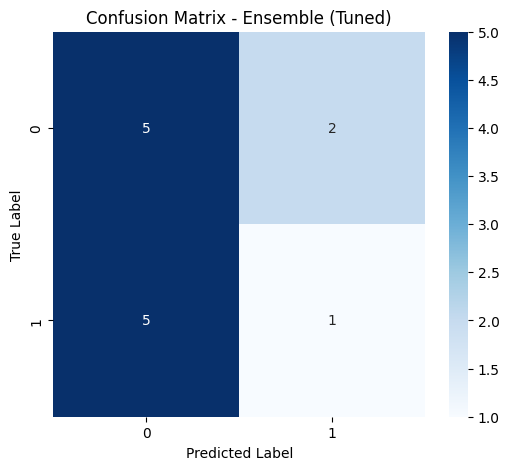

In [38]:
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Ensemble (Tuned)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuracy Comparision

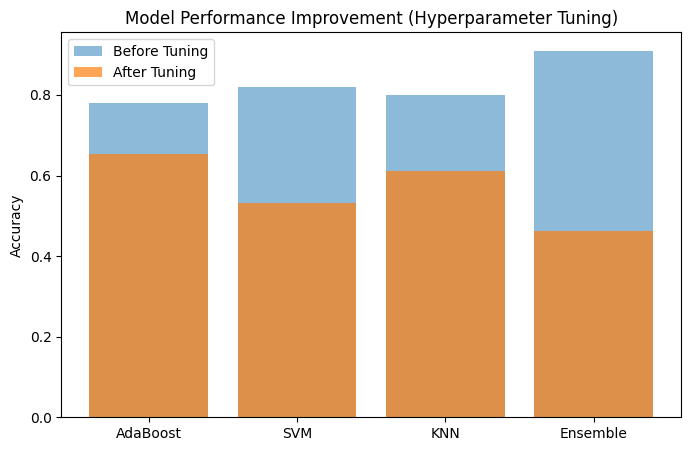

In [39]:
# Accuracy comparison (before vs after tuning)
acc_before = [0.78, 0.82, 0.80, 0.91]
acc_after = [
    grid_ada.best_score_,
    grid_svm.best_score_,
    grid_knn.best_score_,
    accuracy_score(y_test, y_pred)
]

plt.figure(figsize=(8,5))
plt.bar(['AdaBoost', 'SVM', 'KNN', 'Ensemble'], acc_before, alpha=0.5, label='Before Tuning')
plt.bar(['AdaBoost', 'SVM', 'KNN', 'Ensemble'], acc_after, alpha=0.7, label='After Tuning')
plt.title('Model Performance Improvement (Hyperparameter Tuning)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()